In [ ]:
!pip install -U tensorflow-addons
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import math
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.2 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
def Resnet_preprocess(x):
    #return tf.keras.applications.xception.preprocess_input(x)
    return tf.keras.applications.resnet50.preprocess_input(x)

In [ ]:
! cp /content/drive/MyDrive/FaceNet/lfw-deepfunneled-aligned.tgz .
! tar -xvzf lfw-deepfunneled-aligned.tgz

Streaming output truncated to the last 5000 lines.
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/8_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/16_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/32_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/30_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/14_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/29_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/10_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/34_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/36_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/12_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/36_1.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/31_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/28_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/15_0.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva/31_1.jpg
lfw-deepfunneled-aligned/Luiz_Inacio_Lula_da_Silva

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "lfw-deepfunneled-aligned",
  seed=123,
  image_size=(112, 112),
  batch_size=175)

Found 13589 files belonging to 5749 classes.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
def get_model():

    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape = (112, 112, 3))

    # Freeze the base model
    base_model.trainable = False
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Dense(512,activation=None))
    model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))
    return model

def get_modelx():
    
    base_model = tf.keras.applications.Xception(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=(112, 112, 3),
            include_top=False) 

    # Freeze the base model
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(112, 112, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.Dense(512,activation=None)(x)
    outputs = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = get_model()

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 lambda (Lambda)             (None, 512)               0         
                                                        

In [ ]:
print(model.layers[:-1][0])

In [ ]:
for layer in model.layers[:-1]:
  print(layer)

In [ ]:
layer = model.layers[:-1][0]
layer_weights_values = layer.get_weights()
#print(layer_weights_values)

In [ ]:
#to load a existing weight file and continue training
epochs = 50
reg_coef = 1.0

file_name = '/content/drive/MyDrive/Arcface/checkpoint/tripletloss/model_weights_'
file_number = 20
file_name = file_name + str(file_number*epochs)+ '_epochs'
model = tf.keras.models.load_model(file_name)
print(file_name)

In [ ]:
# Instantiate an optimizer to train the model.
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(lr)

In [ ]:
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tfa.losses.TripletSemiHardLoss())

In [ ]:
from keras.callbacks import Callback
class WeightsSaver(Callback):
  def __init__(self, N):
    self.N = N
    self.epoch = 0

  def on_epoch_end(self, epoch, logs={}):
    if self.epoch % self.N == 0:
      file_name = '/content/drive/MyDrive/FaceNet/checkpoint/model_weights_'
      file_name = file_name + str(self.epoch)+ '_epochs'
      model.save(file_name)
      name = 'weights%08d.h5' % self.epoch
      self.model.save_weights(name)
    self.epoch += 1

In [ ]:
epochs = 100
reg_coef = 1.0
file_number = 0

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[WeightsSaver(10)])

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 0.9902

78/78 [==============================] - 74s 822ms/step - loss: 0.9902
Epoch 2/100
78/78 [==============================] - 38s 473ms/step - loss: 0.9717
Epoch 3/100
78/78 [==============================] - 38s 473ms/step - loss: 0.9549
Epoch 4/100
78/78 [==============================] - 39s 491ms/step - loss: 0.9413
Epoch 5/100
78/78 [==============================] - 39s 485ms/step - loss: 0.9255
Epoch 6/100
78/78 [==============================] - 39s 489ms/step - loss: 0.9054
Epoch 7/100
78/78 [==============================] - 39s 488ms/step - loss: 0.8995
Epoch 8/100
78/78 [==============================] - 39s 488ms/step - loss: 0.8740
Epoch 9/100
78/78 [==============================] - 39s 490ms/step - loss: 0.8665
Epoch 10/100
78/78 [==============================] - 39s 488ms/step - loss: 0.8342
Epoch 11/100
78/78 [==============================] - ETA: 0s - loss: 0.8249

78/78 [==============================] - 66s 843ms/step - loss: 0.8249
Epoch 12/100
78/78 [==============================] - 39s 494ms/step - loss: 0.8076
Epoch 13/100
78/78 [==============================] - 39s 490ms/step - loss: 0.7928
Epoch 14/100
78/78 [==============================] - 39s 488ms/step - loss: 0.7630
Epoch 15/100
78/78 [==============================] - 39s 488ms/step - loss: 0.7394
Epoch 16/100
78/78 [==============================] - 39s 487ms/step - loss: 0.7406
Epoch 17/100
78/78 [==============================] - 39s 487ms/step - loss: 0.7290
Epoch 18/100
78/78 [==============================] - 39s 495ms/step - loss: 0.6769
Epoch 19/100
78/78 [==============================] - 39s 487ms/step - loss: 0.6660
Epoch 20/100
78/78 [==============================] - 39s 487ms/step - loss: 0.6386
Epoch 21/100
78/78 [==============================] - ETA: 0s - loss: 0.6091

78/78 [==============================] - 67s 849ms/step - loss: 0.6091
Epoch 22/100
78/78 [==============================] - 40s 495ms/step - loss: 0.6132
Epoch 23/100
78/78 [==============================] - 39s 493ms/step - loss: 0.5830
Epoch 24/100
78/78 [==============================] - 39s 486ms/step - loss: 0.5564
Epoch 25/100
78/78 [==============================] - 39s 491ms/step - loss: 0.5472
Epoch 26/100
78/78 [==============================] - 39s 487ms/step - loss: 0.5503
Epoch 27/100
78/78 [==============================] - 39s 487ms/step - loss: 0.5314
Epoch 28/100
78/78 [==============================] - 40s 496ms/step - loss: 0.5213
Epoch 29/100
78/78 [==============================] - 39s 489ms/step - loss: 0.5050
Epoch 30/100
78/78 [==============================] - 39s 487ms/step - loss: 0.4930
Epoch 31/100
78/78 [==============================] - ETA: 0s - loss: 0.4840

78/78 [==============================] - 66s 847ms/step - loss: 0.4840
Epoch 32/100
78/78 [==============================] - 39s 496ms/step - loss: 0.4784
Epoch 33/100
78/78 [==============================] - 38s 483ms/step - loss: 0.4637
Epoch 34/100
78/78 [==============================] - 39s 488ms/step - loss: 0.5009
Epoch 35/100
78/78 [==============================] - 39s 486ms/step - loss: 0.5171
Epoch 36/100
78/78 [==============================] - 39s 487ms/step - loss: 0.4783
Epoch 37/100
78/78 [==============================] - 39s 494ms/step - loss: 0.4710
Epoch 38/100
78/78 [==============================] - 39s 487ms/step - loss: 0.4741
Epoch 39/100
78/78 [==============================] - 39s 488ms/step - loss: 0.4785
Epoch 40/100
78/78 [==============================] - 39s 487ms/step - loss: 0.4748
Epoch 41/100
78/78 [==============================] - ETA: 0s - loss: 0.4844

78/78 [==============================] - 67s 857ms/step - loss: 0.4844
Epoch 42/100
78/78 [==============================] - 39s 494ms/step - loss: 0.4753
Epoch 43/100
78/78 [==============================] - 38s 484ms/step - loss: 0.4562
Epoch 44/100
78/78 [==============================] - 39s 488ms/step - loss: 0.4793
Epoch 45/100
78/78 [==============================] - 39s 486ms/step - loss: 0.4741
Epoch 46/100
78/78 [==============================] - 39s 493ms/step - loss: 0.5036
Epoch 47/100
78/78 [==============================] - 39s 485ms/step - loss: 0.4936
Epoch 48/100
78/78 [==============================] - 39s 488ms/step - loss: 0.5082
Epoch 49/100
78/78 [==============================] - 39s 486ms/step - loss: 0.4896
Epoch 50/100
78/78 [==============================] - 39s 486ms/step - loss: 0.4786
Epoch 51/100
78/78 [==============================] - ETA: 0s - loss: 0.4767

78/78 [==============================] - 66s 846ms/step - loss: 0.4767
Epoch 52/100
78/78 [==============================] - 39s 494ms/step - loss: 0.4933
Epoch 53/100
78/78 [==============================] - 39s 486ms/step - loss: 0.5023
Epoch 54/100
78/78 [==============================] - 39s 487ms/step - loss: 0.4750
Epoch 55/100
78/78 [==============================] - 39s 490ms/step - loss: 0.4646
Epoch 56/100
78/78 [==============================] - 38s 485ms/step - loss: 0.4503
Epoch 57/100
78/78 [==============================] - 39s 486ms/step - loss: 0.4644
Epoch 58/100
78/78 [==============================] - 39s 486ms/step - loss: 0.4597
Epoch 59/100
78/78 [==============================] - 39s 488ms/step - loss: 0.4554
Epoch 60/100
78/78 [==============================] - 39s 491ms/step - loss: 0.4698
Epoch 61/100
78/78 [==============================] - ETA: 0s - loss: 0.4749

78/78 [==============================] - 66s 838ms/step - loss: 0.4749
Epoch 62/100
78/78 [==============================] - 39s 490ms/step - loss: 0.4603
Epoch 63/100
78/78 [==============================] - 38s 484ms/step - loss: 0.4466
Epoch 64/100
78/78 [==============================] - 39s 489ms/step - loss: 0.4660
Epoch 65/100
78/78 [==============================] - 39s 487ms/step - loss: 0.4734
Epoch 66/100
78/78 [==============================] - 38s 485ms/step - loss: 0.4651
Epoch 67/100
78/78 [==============================] - 39s 488ms/step - loss: 0.5012
Epoch 68/100
78/78 [==============================] - 38s 485ms/step - loss: 0.4970
Epoch 69/100
78/78 [==============================] - 39s 492ms/step - loss: 0.4875
Epoch 70/100
78/78 [==============================] - 38s 485ms/step - loss: 0.4773
Epoch 71/100
78/78 [==============================] - ETA: 0s - loss: 0.4613

78/78 [==============================] - 66s 841ms/step - loss: 0.4613
Epoch 72/100
78/78 [==============================] - 39s 492ms/step - loss: 0.4636
Epoch 73/100
78/78 [==============================] - 39s 487ms/step - loss: 0.4536
Epoch 74/100
78/78 [==============================] - 39s 487ms/step - loss: 0.4627
Epoch 75/100
78/78 [==============================] - 38s 485ms/step - loss: 0.4548
Epoch 76/100
78/78 [==============================] - 38s 483ms/step - loss: 0.4647
Epoch 77/100
78/78 [==============================] - 39s 493ms/step - loss: 0.4645
Epoch 78/100
78/78 [==============================] - 39s 490ms/step - loss: 0.4526
Epoch 79/100
78/78 [==============================] - 38s 485ms/step - loss: 0.4523
Epoch 80/100
78/78 [==============================] - 38s 486ms/step - loss: 0.4606
Epoch 81/100
78/78 [==============================] - ETA: 0s - loss: 0.4636

78/78 [==============================] - 65s 829ms/step - loss: 0.4636
Epoch 82/100
78/78 [==============================] - 40s 498ms/step - loss: 0.4635
Epoch 83/100
78/78 [==============================] - 38s 483ms/step - loss: 0.4623
Epoch 84/100
78/78 [==============================] - 38s 485ms/step - loss: 0.4519
Epoch 85/100
78/78 [==============================] - 39s 487ms/step - loss: 0.4643
Epoch 86/100
78/78 [==============================] - 39s 486ms/step - loss: 0.4405
Epoch 87/100
78/78 [==============================] - 39s 494ms/step - loss: 0.4544
Epoch 88/100
78/78 [==============================] - 39s 487ms/step - loss: 0.4509
Epoch 89/100
78/78 [==============================] - 39s 489ms/step - loss: 0.4566
Epoch 90/100
78/78 [==============================] - 39s 490ms/step - loss: 0.4537
Epoch 91/100
78/78 [==============================] - ETA: 0s - loss: 0.4423

78/78 [==============================] - 67s 854ms/step - loss: 0.4423
Epoch 92/100
78/78 [==============================] - 39s 495ms/step - loss: 0.4284
Epoch 93/100
78/78 [==============================] - 38s 485ms/step - loss: 0.4569
Epoch 94/100
78/78 [==============================] - 39s 486ms/step - loss: 0.4880
Epoch 95/100
78/78 [==============================] - 39s 486ms/step - loss: 0.4619
Epoch 96/100
78/78 [==============================] - 39s 494ms/step - loss: 0.4502
Epoch 97/100
78/78 [==============================] - 39s 488ms/step - loss: 0.4653
Epoch 98/100
78/78 [==============================] - 38s 485ms/step - loss: 0.4604
Epoch 99/100
78/78 [==============================] - 39s 487ms/step - loss: 0.4431
Epoch 100/100
78/78 [==============================] - 38s 485ms/step - loss: 0.4488


In [ ]:
print(history.history)

{'loss': [0.9901871681213379, 0.9716572165489197, 0.9549228549003601, 0.9413023591041565, 0.9255023002624512, 0.9053594470024109, 0.8995429277420044, 0.8740284442901611, 0.8664705157279968, 0.8341988921165466, 0.8249332904815674, 0.8076346516609192, 0.7927569150924683, 0.7630059123039246, 0.739371657371521, 0.7405621409416199, 0.7290061116218567, 0.676932156085968, 0.6659989356994629, 0.638550877571106, 0.6090661883354187, 0.6131859421730042, 0.5829520225524902, 0.5563592910766602, 0.5472174882888794, 0.550293505191803, 0.5313979387283325, 0.5213046669960022, 0.5050109624862671, 0.4929944574832916, 0.48395848274230957, 0.4784128963947296, 0.46366623044013977, 0.5009034276008606, 0.5171048641204834, 0.47831425070762634, 0.470983624458313, 0.4741223454475403, 0.4785320460796356, 0.47481441497802734, 0.4844183325767517, 0.47528907656669617, 0.45618006587028503, 0.4792514443397522, 0.4741447865962982, 0.5035611391067505, 0.49355340003967285, 0.5081921219825745, 0.48956674337387085, 0.47855

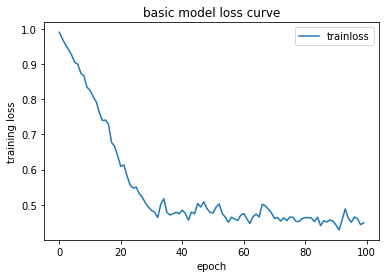

In [20]:
plt.plot(history.history['loss'])
plt.title('basic model loss curve')
plt.ylabel('training loss')
plt.xlabel('epoch')
plt.legend(['trainloss'], loc='upper right')
plt.show()